# Circuit Cutting with Manual Wire Cutting

Circuit cutting is a technique to decompose a quantum circuit into smaller circuits, whose results can be knitted together to reconstruct the original circuit output. 

The circuit knitting toolbox implements a wire cutting method presented in [CutQC](https://doi.org/10.1145/3445814.3446758) (Tang et al.). This method allows a circuit wire to be cut such that the generated subcircuits are amended by measurements in the Pauli bases and by state preparation of four Pauli eigenstates (see Fig. 4 of [CutQC](https://doi.org/10.1145/3445814.3446758)).

This wire cutting technique is comprised of the following basic steps:

1. **Decompose**: Cut a circuit into multiple subcircuits. Here, we'll use a manual method to specify the cut(s). See [tutorial 1](tutorial_1_circuit_cutting_automatic_cut_finding.ipynb) to automatically cut a circuit.
2. **Evaluate**: Execute those subcircuits on quantum backend(s).
3. **Reconstruct**: Knit the subcircuit results together to reconstruct the original circuit output (in this case, the full probability distribution).

## Create a quantum circuit with Qiskit

In this tutorial, we'll use the example circuit shown in [CutQC](https://dl.acm.org/doi/10.1145/3445814.3446758).

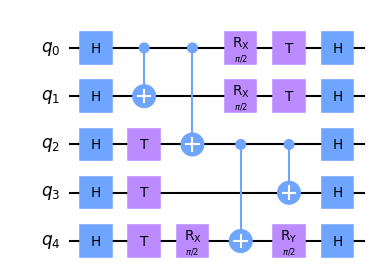

In [1]:
import numpy as np
from qiskit import QuantumCircuit

num_qubits = 5

circuit = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    circuit.h(i)
circuit.cx(0, 1)
for i in range(2, num_qubits):
    circuit.t(i)
circuit.cx(0, 2)
circuit.rx(np.pi / 2, 4)
circuit.rx(np.pi / 2, 0)
circuit.rx(np.pi / 2, 1)
circuit.cx(2, 4)
circuit.t(0)
circuit.t(1)
circuit.cx(2, 3)
circuit.ry(np.pi / 2, 4)
for i in range(num_qubits):
    circuit.h(i)

circuit.draw("mpl", fold=-1, scale=0.75)

## Set up the Qiskit Runtime Service

The Qiskit Runtime Service provides access to IBM Runtime Primitives and quantum backends.
Alternatively, a local statevector simulator can be used with the Qiskit primitives.

In [2]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)

service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<YOUR_API_TOKEN>",
)

The wire cutter tool uses a `Sampler` primitive to evaluate the probabilities of each subcircuit. Here, we configure the options for the Runtime Sampler and specify the backend(s) to be used to evaluate the subcircuits:

In [3]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

## Set up the Wire Cutter from the Circuit Knitting Toolbox

Instantiate a `WireCutter` with the circuit and runtime information.

In [4]:
from circuit_knitting_toolbox.circuit_cutting import WireCutter

cutter = WireCutter(
    circuit, service=service, backend_names=backend_names, options=options
)

Note: if only a circuit is passed to `WireCutter`, a local Qiskit Sampler with the statevector simulator will be used instead:<br>
```cutter = WireCutter(circuit)```

## Decompose the circuit with wire cutting

In this example, we will use a manual method to specify the wire cuts. See [tutorial 1](tutorial_1_circuit_cutting_automatic_cut_finding.ipynb) for how to automatically cut a circuit.
   * `method='manual`: Manually specify the wire cuts
   * `subcircuit_vertices`: A list of vertices to be used in subcircuits

In [5]:
cuts = cutter.decompose(method="manual", subcircuit_vertices=[[0, 1], [2, 3]])

2022-10-22 12:32:03,763	INFO worker.py:1518 -- Started a local Ray instance.


(cut_circuit_wires pid=8239) --------------------
(cut_circuit_wires pid=8239) subcircuit 0
(cut_circuit_wires pid=8239) ρ qubits = 0, O qubits = 1, width = 3, effective = 2, depth = 6, size = 12
(cut_circuit_wires pid=8239)      ┌───┐                     ┌─────────┐┌───┐┌───┐
(cut_circuit_wires pid=8239) q_0: ┤ H ├──■───────────────■──┤ Rx(π/2) ├┤ T ├┤ H ├
(cut_circuit_wires pid=8239)      ├───┤┌─┴─┐┌─────────┐  │  └──┬───┬──┘├───┤└───┘
(cut_circuit_wires pid=8239) q_1: ┤ H ├┤ X ├┤ Rx(π/2) ├──┼─────┤ T ├───┤ H ├─────
(cut_circuit_wires pid=8239)      ├───┤├───┤└─────────┘┌─┴─┐   └───┘   └───┘     
(cut_circuit_wires pid=8239) q_2: ┤ H ├┤ T ├───────────┤ X ├─────────────────────
(cut_circuit_wires pid=8239)      └───┘└───┘           └───┘                     
(cut_circuit_wires pid=8239) subcircuit 1
(cut_circuit_wires pid=8239) ρ qubits = 1, O qubits = 0, width = 3, effective = 3, depth = 6, size = 11
(cut_circuit_wires pid=8239)                                           ┌───┐
(cut_ci

## Evaluate the subcircuits with Qiskit Runtime


Note that two local cores will be used to support each of the parallel backend threads we specified earlier. See [tutorial 1](tutorial_1_circuit_cutting_automatic_cut_finding.ipynb) for more info about the subcircuit results.

In [6]:
subcircuit_instance_probabilities = cutter.evaluate(cuts)

## Reconstruct the full circuit output

Next, the results of the subcircuit experiments are classical postprocessed to reconstruct an estimate of the original circuit's full probability distribution.

In [7]:
%%capture

reconstructed_probabilities = cutter.reconstruct(
    subcircuit_instance_probabilities, cuts
)

Here are the reconstructed probabilities for the original 5-qubit circuit:

In [8]:
print(
    "Size of reconstructed probability distribution: ", len(reconstructed_probabilities)
)

Size of reconstructed probability distribution:  32


## Verify the results

If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's exact probability distribution (ground truth).

In [9]:
metrics, exact_probabilities = cutter.verify(reconstructed_probabilities)

The verify step includes several metrics, including the chi square loss. More info about each metric can be found in the [utils metrics file](https://github.com/Qiskit-Extensions/circuit-knitting-toolbox/blob/main/circuit_knitting_toolbox/utils/metrics.py).

In [10]:
metrics

{'nearest': {'chi2': 0.0016480859293148851,
  'Mean Squared Error': 2.2735561224425387e-06,
  'Mean Absolute Percentage Error': 9.116161020394516,
  'Cross Entropy': 2.6013770444786495,
  'HOP': 0.9068189188838005},
 'naive': {'chi2': 0.0016480859293148851,
  'Mean Squared Error': 2.2735561224425387e-06,
  'Mean Absolute Percentage Error': 9.116161020394516,
  'Cross Entropy': 2.6013770444786495,
  'HOP': 0.9068189188838005}}

If we calculated the ground truth above, we can visualize a comparison to the reconstructed probabilities

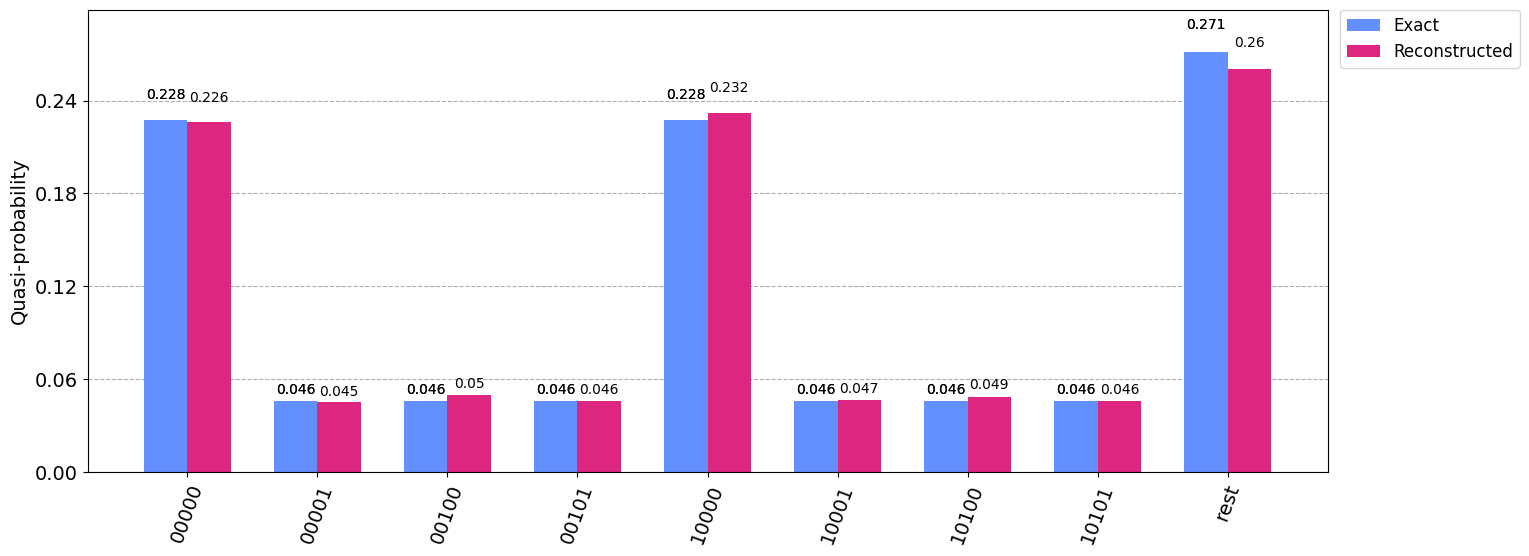

In [11]:
from qiskit.visualization import plot_histogram
from qiskit.result import ProbDistribution

# Create a dict for the reconstructed distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Represent states as bitstrings (instead of ints)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)


# Create the ground truth distribution dict
exact_distribution = {i: prob for i, prob in enumerate(exact_probabilities)}

# Represent states as bitstrings (instead of ints)
exact_dict_bitstring = ProbDistribution(data=exact_distribution).binary_probabilities(
    num_bits=num_qubits
)

# plot a histogram of the distributions
plot_histogram(
    [exact_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 6),
    sort="asc",
    legend=["Exact", "Reconstructed"],
)

In [12]:
import qiskit.tools.jupyter

%qiskit_version_table

This code is a Qiskit project.
© Copyright IBM 2022.

This code is licensed under the Apache License, Version 2.0. You may
obtain a copy of this license in the LICENSE.txt file in the root directory
of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this
copyright notice, and modified files need to carry a notice indicating
that they have been altered from the originals.